In [1]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [3]:
class CellDataset(keras.utils.Sequence):
    def __init__(self, path, num_images, batch_size):
        self.path = path
        self.batch_size = batch_size
        self.num_images = num_images

    def __getitem__(self, idx):
        start = idx * self.batch_size
        images = []
        masks = []
        for i in range(start, start + self.batch_size):
            img_path = self.path + 'images/' + str(i) + '.jpg'
            mask_path = self.path + 'masks/' + str(i) + '.jpg'
            img = tf.keras.utils.img_to_array(load_img(img_path))[:,:,0]
            mask = tf.keras.utils.img_to_array(load_img(mask_path))[:,:,0] / 255
            images.append(img)
            masks.append(mask)
        
        images = np.stack(images)
        masks = np.stack(masks)

        return images, masks

    def __len__(self):
        return self.num_images // self.batch_size

(10, 520, 704) (10, 520, 704)


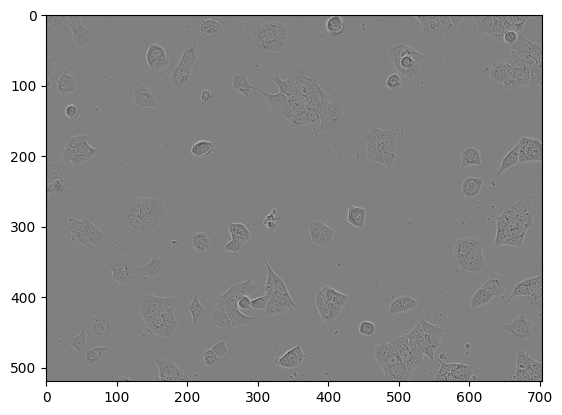

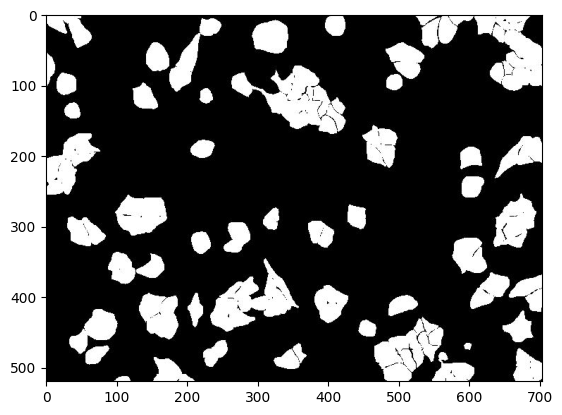

In [4]:
a = CellDataset("../dataset/val/", 500, 10)

i, m = next(iter(a))
print(i.shape, m.shape)

from matplotlib import pyplot as plt
plt.imshow(i[7], cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(m[7]*255, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
from tensorflow.keras import layers

def get_model():
    inputs = keras.Input(shape=(520, 704, 1))

    x = layers.Conv2D(4, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # x = layers.UpSampling2D(2)(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [8]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [8, 4]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 520, 704, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 260, 352, 4)  40          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 260, 352, 4)  16         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
train_gen = CellDataset("../dataset/train/", 3253, 8)
val_gen = CellDataset("../dataset/train/", 570, 8)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer="rmsprop", loss="mean_squared_error")

callbacks = [
    keras.callbacks.ModelCheckpoint("nn_results", save_best_only=True)
]

epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
val_preds = model.predict(val_gen)

71/71 [==============================] - 7s 101ms/step


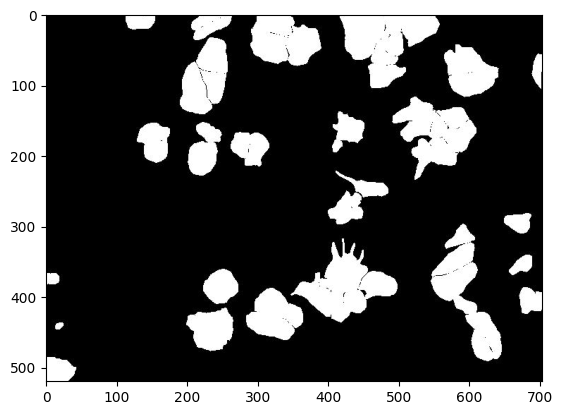

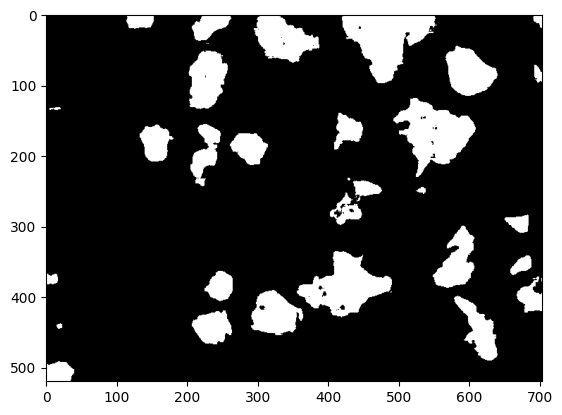

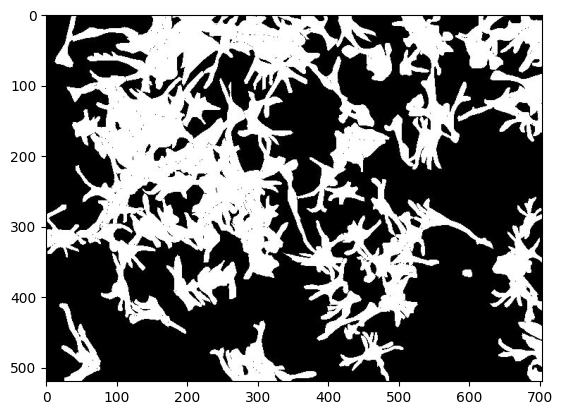

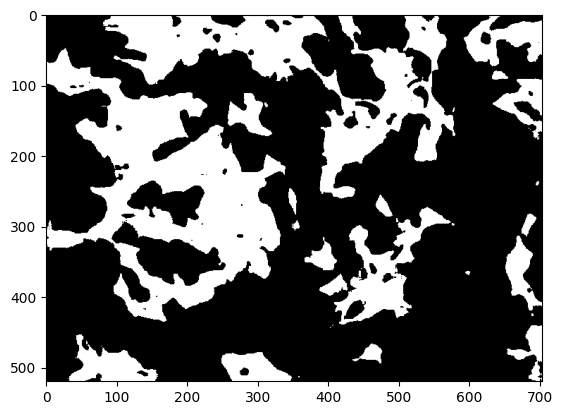

In [ ]:
# print(val_preds.shape)

model = keras.models.load_model('nn_results')
val_preds = model.predict(val_gen)

input, actual = val_gen[0]
plt.imshow(actual[7]*255, cmap='gray', vmin=0, vmax=255)
plt.show()

temp = val_preds[7]
temp[temp >= 0.5] = 1
temp[temp < 0.5] = 0
example = (temp*255).astype('uint8')
plt.imshow(example, cmap='gray', vmin=0, vmax=255)
plt.show()

plt.imshow(actual[4]*255, cmap='gray', vmin=0, vmax=255)
plt.show()

temp = val_preds[4]
temp[temp >= 0.5] = 1
temp[temp < 0.5] = 0
example = (temp*255).astype('uint8')
plt.imshow(example, cmap='gray', vmin=0, vmax=255)
plt.show()



